In [1]:
###################
# from U-Net
###################
import os
import sys
import glob
import random
import datetime
import warnings


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from itertools import chain
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


######################
#from mask-RCNN
######################
import cv2

# to ignore warnings
warnings.filterwarnings('ignore')
#to plot things inline in jupyter
%matplotlib inline

Using TensorFlow backend.


# Loading u-net

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

### testing an image with u-net

# Loading mask-RCNN

In [2]:
import utils as utl
#from hs_config import hs_config 
#instead of importing the variable (the config file), import the class to be overriden
from hs_config import HsConfig
from bowl_dataset import BowlDataset
import hsModel as modellib
import functions as f


import visualize
from visualize import display_images
from hsModel import log


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        512
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               256
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hsConfig
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAININ

original had an inference_config in <br>model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR) <br> but i changed it to hs_config (before the weights were for resNet101, but resnet50 was being loaded). 
Also, since the batch size for resNet101 training was 2, here we need to suply to images for prediction.

<font color='red'>The issue with batch size in inference can be resolved by creating a config, that sets the batchsize to 1, this is why they had an inference_config to beging with. </font>


In [3]:
# Override the training config (hsConfig) with a few
# changes for inferencing.
class HsInferenceConfig(HsConfig):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    IMAGE_MIN_DIM = 128 # hs chaging this to 128 failed I think
    RESNET_ARCHITECTURE = 'resnet50'

hs_inference_config = HsInferenceConfig()
hs_inference_config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        512
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               256
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hsConfig
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAININ

In [4]:
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [5]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=hs_inference_config,
                          model_dir=MODEL_DIR)
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
model_path = os.path.join(MODEL_DIR, 'hsconfig20180316T2211/mask_rcnn_hsconfig_0009.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/hooman67/Cell_Nuclei_Segmentation/kaggle-ds-bowl-2018-baseline/logs/hsconfig20180320T0252/mask_rcnn_hsconfig_0001.h5


# hs Visualizing gt and prediction for investigation

In [7]:
'''
# To display the masks in individual plots use
display_images(np.transpose(gt_masks, [2, 0, 1]), range(25), cmap="Blues")

# to display all the masks on one plot use
plt.imshow(displayMasksOnOnePlot(gt_masks), cmap="Blues")
'''

# HS helper for display all masks on one plot
def displayMasksOnOnePlot(masks, figsize=(8, 8)):
    images = np.transpose(masks, [2, 0, 1])

    bigIm = images[0,:,:].astype(np.uint8)
    bigIm[:,:] = 0
    for image in images:
        tempIm = image.astype(np.uint8)
        bigIm = bigIm + tempIm
        
    height, width = masks.shape[1], masks.shape[1] 
    _, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(bigIm,cmap="Blues")
    plt.show()

    #return bigIm


# hs helper for plotting
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:
# hs load training set
training_set = BowlDataset()
training_set.load_bowl('stage1_train')
training_set.prepare()
print(training_set.class_info)

[{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'bowl', 'id': 1, 'name': 'nuclei'}]


In [10]:
# hs load all the ground truth info for an image
hs_image_id = 50
gt_image, gt_image_meta, gt_class_ids, gt_bbox, gt_masks = modellib.load_image_gt(training_set, hs_inference_config, hs_image_id)
print(gt_image.shape)
print(gt_masks.shape)
print(gt_bbox.shape)
print(gt_class_ids.shape)

(512, 512, 3)
(512, 512, 91)
(91, 4)
(91,)


In [11]:
# HS run the model to perform detection and segmentation
results = model.detect([gt_image], verbose=1)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


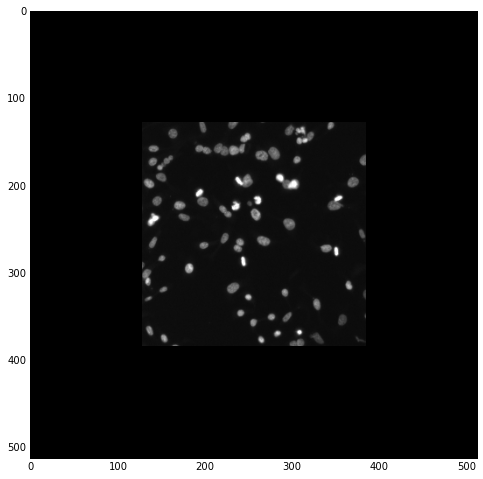

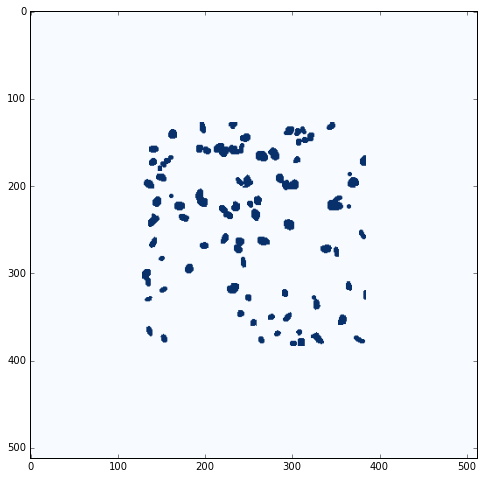

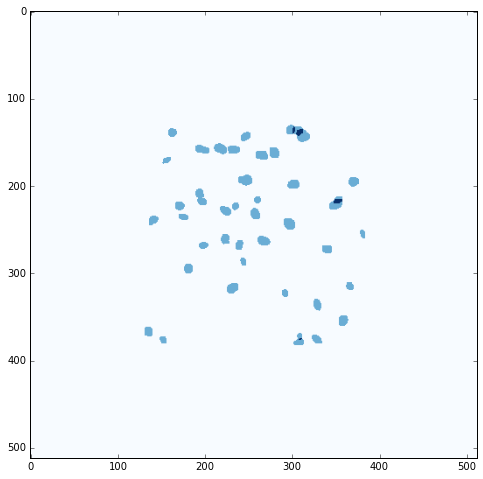

In [13]:
#hs display ground truth image
_, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(gt_image)


#hs display ground truth masks (all on one plot)
displayMasksOnOnePlot(gt_masks, figsize=(8, 8))


#hs display predicted masks
r1 = results[0]
pred_masks = r1['masks']
#to show just one mask
#plt.imshow(results[0]['masks'][:,:,1])

displayMasksOnOnePlot(pred_masks, figsize=(8, 8))

In [14]:
# For image1 we could only segment 14 out of 28 masks in GT
# gt_image.shape     == (512, 512, 3)
# gt_masks.shape     == (512, 512, 28)
# gt_bbox.shape      == (28, 4)
# gt_class_ids.shape == (28,)

# r['masks'].shape     == (512, 512, 14)
# r['rois'].shape      == (14, 4)
# r['class_ids'].shape == (14,)
# r['scores'].shape    == (14,)

print(r1['masks'].shape)
print(gt_masks.shape)
print(r1['rois'].shape )
print(gt_bbox.shape)
print(r1['class_ids'].shape)
print(gt_class_ids.shape)
print(r1['scores'].shape)
print(gt_image.shape)

(512, 512, 44)
(512, 512, 91)
(44, 4)
(91, 4)
(44,)
(91,)
(44,)
(512, 512, 3)


# Reinforcement Learning

### From mask_RCNN

In [24]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [25]:
molded_images, image_metas, windows = model.mold_inputs([gt_image, gt_image2])
detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, \
            rois, rpn_class, rpn_bbox =\
            model.keras_model.predict([molded_images, image_metas], verbose=0)

In [26]:
print(detections.shape)   # (2, 512, 6)
print(mrcnn_class.shape)  # (2, 1000, 2)
print(mrcnn_bbox.shape)   # (2, 1000, 2, 4)
print(mrcnn_mask.shape)   # (2, 512, 28, 28, 2)
print(rois.shape)         # (2, 1000, 4)
print(rpn_class.shape)    # (2, 65472, 2)
print(rpn_bbox.shape)     # (2, 65472, 4)

(2, 512, 6)
(2, 1000, 2)
(2, 1000, 2, 4)
(2, 512, 28, 28, 2)
(2, 1000, 4)
(2, 65472, 2)
(2, 65472, 4)


In [30]:
# Process detections
results = []
for i, image in enumerate([gt_image, gt_image2]):
    final_rois, final_class_ids, final_scores, final_masks =\
        model.unmold_detections(detections[i], mrcnn_mask[i],
                               image.shape, windows[i])
    results.append({
        "rois": final_rois,
        "class_ids": final_class_ids,
        "scores": final_scores,
        "masks": final_masks,
    })

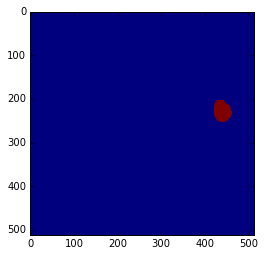

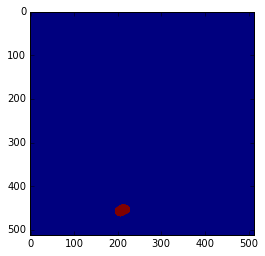

In [31]:
r1 = results[0]
r2 = results[1]

plt.figure()
plt.imshow(r1['masks'][:,:,1])

plt.figure()
plt.imshow(r2['masks'][:,:,1])

### From U-Net

In [1]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
model.summary()

NameError: name 'load_model' is not defined

In [ ]:
xx = model.get_layer('conv2d_18').output
new_baseMod = Model(model.input, xx)
new_baseMod.summary()

In [ ]:
yy = model.get_layer('conv2d_19') (xx)
new_model = Model(model.input, yy)
new_model.summary()